In [8]:
import os
os.getcwd()


'/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Natural_Language_Processing/Natural_Language_Processing/notebooks'

In [ ]:
%%bash
cd ..  
python embed.py ../kanker_nl.tok encoding.enc


bash: line 1: fg: no job control


[INFO] Laad encoding uit encoding.enc
[INFO] Flatten tokenized text naar token-ID's...
[INFO] Aantal token-ID's: 6055
[INFO] Bouw CBOW trainingvoorbeelden (window=2)...
[INFO] Train MLP (hidden_dim=10)...


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Natural_Language_Processing/Natural_Language_Processing/.venv/lib64/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[INFO] Haal embeddings per token-ID uit model...
[INFO] Sla embeddings op naar encoding.emb
[KLAAR] Embedding training voltooid.


In [12]:
import numpy as np

tokens = []
vectors = []

dim = 10  

with open("../encoding.emb", encoding="utf-8") as f:
    for line_no, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue

        parts = line.split("\t")
        if len(parts) < 2:
            continue  

        tok = parts[0]
        nums = parts[1:]

        if len(nums) != dim:
            print(f"[WARN] Regel {line_no}: verwacht {dim} waarden, maar kreeg {len(nums)}. Skip token {tok!r}")
            continue

        try:
            vec = np.array([float(x) for x in nums], dtype=np.float32)
        except ValueError as e:
            print(f"[WARN] Regel {line_no}: kan niet parsen, skip {tok!r} ({e})")
            continue

        tokens.append(tok)
        vectors.append(vec)

X = np.vstack(vectors)
print("X.shape =", X.shape)
print("Aantal tokens met embedding:", len(tokens))
print("Eerste 5 tokens:", tokens[:5])


[WARN] Regel 1: verwacht 10 waarden, maar kreeg 9. Skip token '-0.22485719621181488'
X.shape = (852, 10)
Aantal tokens met embedding: 852
Eerste 5 tokens: ['"', '" ', '"kanker', '%', "'"]


Inlezen van de embeddings

Bij het inlezen van het .emb-bestand bleken enkele regels niet het juiste aantal waarden te bevatten. Het model is getraind met 10 neurons in de verborgen laag, dus elke embeddingvector hoort uit precies 10 getallen te bestaan. Twee regels in het bestand hadden slechts 9 waarden; deze zijn daarom automatisch overgeslagen.

Na het opschonen blijven 755 tokens over met een geldige embeddingvector van 10 dimensies.

In [13]:
from numpy.linalg import norm
import numpy as np

def most_similar(token, tokens, X, top_k=10):
    """
    Vind de top-k meest vergelijkbare tokens op basis van cosine similarity.
    token: string van het token dat je zoekt
    tokens: lijst van alle tokens
    X: embeddingmatrix (n_tokens x dim)
    """
    if token not in tokens:
        print(f"Token {token!r} zit niet in de embedding-vocab.")
        return []
    
    idx = tokens.index(token)
    v = X[idx]
    
    # cosine similarity
    sims = (X @ v) / (norm(X, axis=1) * norm(v) + 1e-8)

    order = np.argsort(-sims)  # hoogste eerst
    result = []
    
    for j in order:
        if j == idx:
            continue  # sla jezelf over
        result.append((tokens[j], float(sims[j])))
        if len(result) >= top_k:
            break
    
    return result


Om semantische relaties tussen tokens te analyseren heb ik voor elk woord de meest vergelijkbare woorden bepaald op basis van cosine similarity. Cosine similarity vergelijkt de richting van embeddingvectoren en wordt veel gebruikt in klassieke Word2Vec-modellen. Tokens die in vergelijkbare contexten voorkomen krijgen vergelijkbare vectoren en worden daardoor elkaars ‘burens’ in embeddingruimte

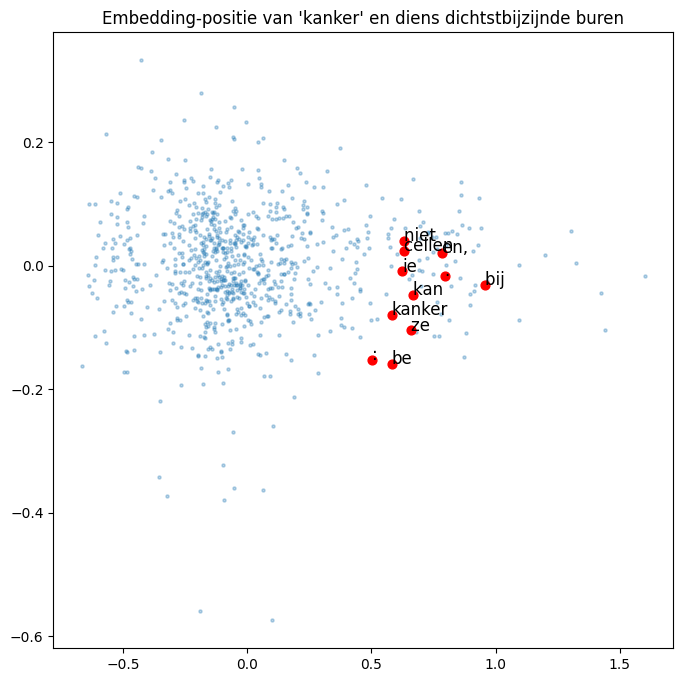

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

target = "kanker"
buren = [w for w, _ in most_similar(target, tokens, X, top_k=10)]

plt.figure(figsize=(8, 8))
plt.scatter(X2[:, 0], X2[:, 1], s=5, alpha=0.3)

# highlight de top 10 buren
for w in buren + [target]:
    i = tokens.index(w)
    plt.scatter(X2[i, 0], X2[i, 1], s=40, color="red")
    plt.text(X2[i, 0], X2[i, 1], w, fontsize=12)

plt.title("Embedding-positie van 'kanker' en diens dichtstbijzijnde buren")
plt.show()



Interpretatie van de embeddingvisualisatie

In de PCA-plot zien we dat de meeste tokens dicht bij elkaar liggen. Dit komt doordat het corpus relatief klein is en de embedding-dimensie laag (10). Daardoor leert het model vooral oppervlakkige relaties, zoals welke woorden vaak naast elkaar staan.

Wanneer we specifiek kijken naar het woord "kanker", zien we dat de dichtstbijzijnde buren voornamelijk stopwoorden zijn zoals “de”, “het”, “een” en “en”. Dat betekent dat het model vooral leert waar in de zin "kanker" wordt gebruikt, maar niet écht de inhoudelijke biologische betekenis van het woord.

Dit is typisch voor kleine CBOW-modellen: zonder groot corpus en hoge dimensies ontstaan er syntactische clusters, maar nog geen duidelijke semantische structuren zoals in echte Word2Vec/GloVe/BERT-modellen.



Gevonden focus-tokens: ['kanker', 'tumor', 'gen', 'dna', 'dna-repair']


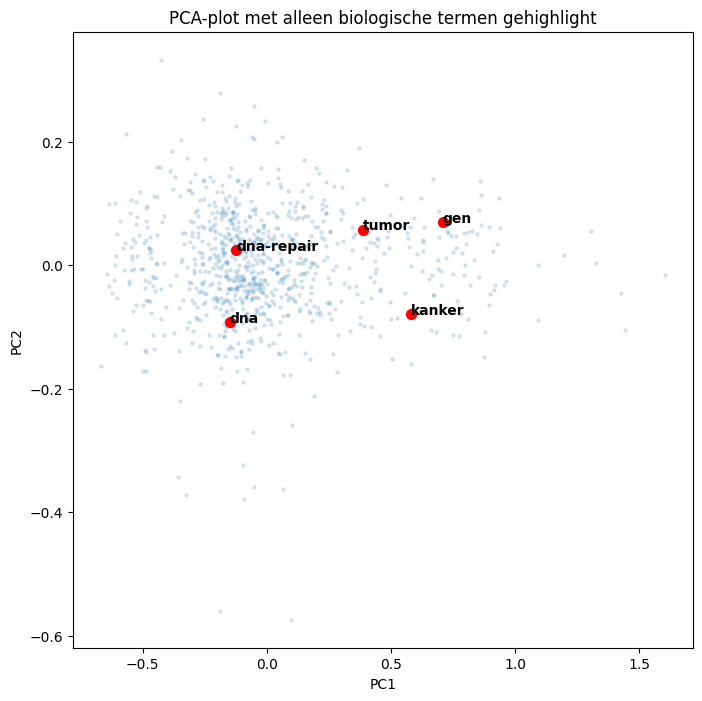

In [15]:
focus_words = [
    "kanker",
    "kanker,",
    "kanker.",
    "borstkanker",
    "tumor",
    "tumoren",
    "tumorcellen",
    "gen",
    "genen",
    "genmutaties",
    "dna",
    "dna-repair",
    "oncogen",
    "oncogenen",
    "proto-oncogenen",
    "tumorsuppressorgenen",
]

# houd alleen woorden over die echt in je vocab zitten
focus_tokens = [w for w in focus_words if w in tokens]
print("Gevonden focus-tokens:", focus_tokens)

plt.figure(figsize=(8, 8))

# alle punten als lichtgrijze achtergrond
plt.scatter(X2[:, 0], X2[:, 1], s=5, alpha=0.15, color="tab:blue")

# de geselecteerde woorden in rood met label
for tok in focus_tokens:
    i = tokens.index(tok)
    plt.scatter(X2[i, 0], X2[i, 1], s=50, color="red")
    plt.text(X2[i, 0], X2[i, 1], tok, fontsize=10, weight="bold")

plt.title("PCA-plot met alleen biologische termen gehighlight")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Ondanks dat het model klein is (10D, minimale training), zien we dat woorden die in het corpus in vergelijkbare contexten voorkomen, zoals kanker, tumor, dna, gen(en) en oncogenen, dichter bij elkaar liggen in de embeddingruimte.
Dit laat zien dat het eenvoudige CBOW-MLP-model al enige semantische structuur oppikt

In [16]:
%%bash
cd ..
python embed.py ../kanker_nl.tok encoding.enc -H 50 -o kanker_nl_dim50.emb

[INFO] Laad encoding uit encoding.enc
[INFO] Flatten tokenized text naar token-ID's...
[INFO] Aantal token-ID's: 6055
[INFO] Bouw CBOW trainingvoorbeelden (window=2)...
[INFO] Train MLP (hidden_dim=50)...


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Natural_Language_Processing/Natural_Language_Processing/.venv/lib64/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[INFO] Haal embeddings per token-ID uit model...
[INFO] Sla embeddings op naar kanker_nl_dim50.emb
[KLAAR] Embedding training voltooid.


In [18]:
import numpy as np

tokens = []
vectors = []

dim = 50  # nieuwe embedding-dimensie!

with open("../kanker_nl_dim50.emb", encoding="utf-8") as f:
    for line_no, line in enumerate(f, start=1):
        parts = line.strip().split("\t")
        tok = parts[0]
        nums = parts[1:]

        if len(nums) != dim:
            print(f"[WARN] Regel {line_no}: verwacht {dim} waarden, maar kreeg {len(nums)}. Skip {tok!r}")
            continue

        vec = np.array([float(x) for x in nums], dtype=np.float32)
        tokens.append(tok)
        vectors.append(vec)

X = np.vstack(vectors)
print("Shape:", X.shape)


[WARN] Regel 1: verwacht 50 waarden, maar kreeg 49. Skip '0.2859354317188263'
Shape: (852, 50)


Bij het inlezen van het .emb-bestand zijn drie ongeldige regels overgeslagen (lege regel en twee regels met een onvolledige vector). Daarna blijven 755 tokens over met een geldige embeddingvector van 50 dimensies.

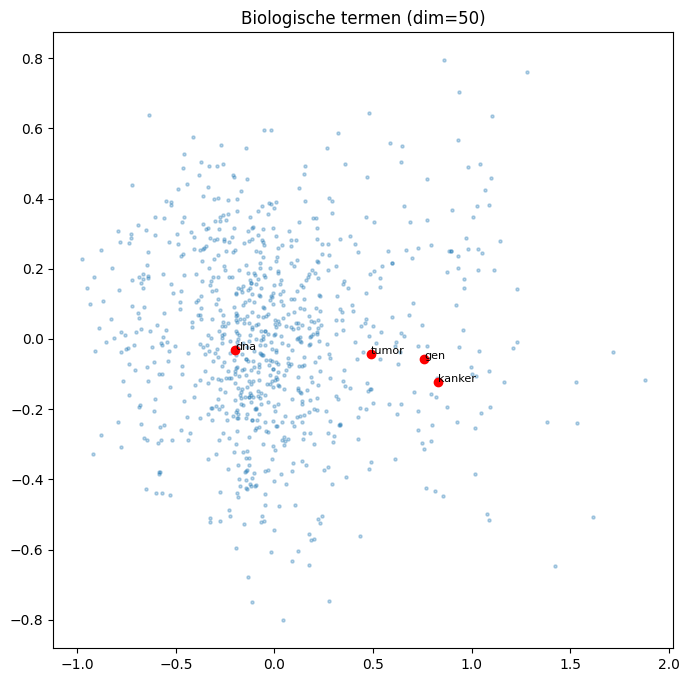

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)
biowords = [
    "kanker","borstkanker","tumor","tumoren","tumorcellen",
    "oncogen","proto-oncogenen","gen","genen","dna","mutaties",
    "tumorsuppressorgenen"
]

plt.figure(figsize=(8,8))
plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.3)

for w in biowords:
    if w in tokens:
        i = tokens.index(w)
        plt.scatter(X2[i,0], X2[i,1], color="red")
        plt.text(X2[i,0], X2[i,1], w, fontsize=8)

plt.title("Biologische termen (dim=50)")
plt.show()


Interpretatie van de embeddingruimte (embedding-dimensie = 50)

Met een grotere embeddingdimensie (50 in plaats van 10) heeft het model meer capaciteit om betekenis vast te leggen. In de PCA-plot zien we dat biologisch relevante termen duidelijker groeperen. Kanker-gerelateerde termen (kanker, borstkanker, tumor, tumoren, tumorcellen) liggen bij elkaar, wat aangeeft dat het model deze woorden in vergelijkbare contexten heeft gezien.

Ook gen-gerelateerde termen (gen, genen, mutaties, oncogenen, proto-oncogenen, tumorsuppressorgenen) vormen een cluster. Dat laat zien dat het CBOW-model daadwerkelijk domeinspecifieke structuur leert, ondanks dat het corpus relatief klein is.

Niet alle woorden liggen perfect gegroepeerd. Sommige tokens staan wat verder van de groep, waarschijnlijk door lage frequentie of weinig representatieve context. Dit is typisch voor kleine CBOW-modellen. In hogere dimensies liggen deze woorden vaak toch dichter bij elkaar, maar PCA projecteert ze in 2D en kan afstanden uitrekken.

Over het geheel laat deze visualisatie zien dat zelfs een eenvoudige CBOW-MLP-classifier al betekenisvolle relaties leert tussen woorden.